In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib

In [2]:
df = pd.read_csv('house_prices.csv')
print(df.shape)
print(df.head())

(99499, 9)
   Unnamed: 0 property_type     price     location       city  baths  \
0           0          Flat  10000000         G-10  Islamabad      2   
1           1          Flat   6900000         E-11  Islamabad      3   
2           2         House  16500000         G-15  Islamabad      6   
3           3         House  43500000    Bani Gala  Islamabad      4   
4           4         House   7000000  DHA Defence  Islamabad      3   

    purpose  bedrooms  Area_in_Marla  
0  For Sale         2            4.0  
1  For Sale         3            5.6  
2  For Sale         5            8.0  
3  For Sale         4           40.0  
4  For Sale         3            8.0  


In [4]:
df = pd.read_csv('house_prices.csv')

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

print("Cleaned Dataset:", df.shape)

Cleaned Dataset: (99499, 9)


In [5]:
df = df.dropna(subset=["price", "Area_in_Marla"])

df = df[(df["price"] < df["price"].quantile(0.99)) & (df["price"] > df["price"].quantile(0.01))]

df["price_per_marla"] = df["price"] / df["Area_in_Marla"]
df["area_category"] = pd.cut(
    df["Area_in_Marla"],
    bins=[0, 5, 10, 20, 40, np.inf],
    labels=["Small", "Medium", "Large", "Luxury", "Mega"]
)

df["log_price"] = np.log(df["price"])


In [6]:
features = [
    "property_type", "location", "city", "baths",
    "bedrooms", "Area_in_Marla", "price_per_marla", "area_category"
]
target = "log_price"

X = df[features]
y = df[target]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
numeric_features = ["baths", "bedrooms", "Area_in_Marla", "price_per_marla"]
categorical_features = ["property_type", "location", "city", "area_category"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

for col in numeric_features:
    X_train[col] = X_train[col].replace([np.inf, -np.inf], np.nan)
    X_test[col] = X_test[col].replace([np.inf, -np.inf], np.nan)

In [9]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", xgb)
])


In [10]:
print("NaN values per column:\n", df.isnull().sum())

numeric_cols = df.select_dtypes(include=np.number).columns
print("\nAny infinite values in numeric columns?:", np.isinf(df[numeric_cols]).values.any())

NaN values per column:
 Unnamed: 0         0
property_type      0
price              0
location           0
city               0
baths              0
purpose            0
bedrooms           0
Area_in_Marla      0
price_per_marla    0
area_category      9
log_price          0
dtype: int64

Any infinite values in numeric columns?: True


In [11]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

df.dropna(inplace=True)

print("Cleaned dataset shape:", df.shape)


Cleaned dataset shape: (97421, 12)


In [12]:
import numpy as np
print("Any NaN in X_train?", np.isnan(X_train.select_dtypes(include=[np.number])).any().any())
print("Any inf in X_train?", np.isinf(X_train.select_dtypes(include=[np.number])).any().any())


Any NaN in X_train? True
Any inf in X_train? False


In [13]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log)
y_true = np.exp(y_test)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_true, y_pred)

print(f"Improved RMSE: {rmse:,.0f}")
print(f"Improved R² Score: {r2:.3f}")

Improved RMSE: 548,530
Improved R² Score: 0.997


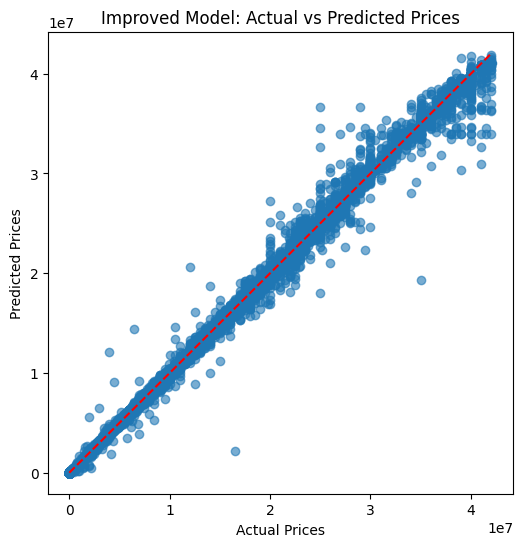

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Improved Model: Actual vs Predicted Prices")
plt.show()

In [18]:
joblib.dump(model, "improved_house_price_model.pkl")
print("Model saved as improved_house_price_model.pkl")

Model saved as improved_house_price_model.pkl


In [20]:
sample = pd.DataFrame([{
    "property_type": "House",
    "location": "DHA Defence",
    "city": "Islamabad",
    "baths": 4,
    "bedrooms": 4,
    "Area_in_Marla": 10,
    "price_per_marla": 7000000/10,
    "area_category": "Medium"
}])

predicted_log_price = model.predict(sample)[0]
predicted_price = np.exp(predicted_log_price)
print(f" Predicted Price: Rs {predicted_price:,.0f}")

 Predicted Price: Rs 6,809,366
